# Neural network for classification of contaminants with MAT

## 1. Formulate/outline the problem: classification

Simple neural network for classification of the contaminants using MAT transcriptomes


In [20]:
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
import wandb
import tensorflow as tf
from tensorflow import keras

In [21]:
file_name = "gene_counts_NN_training.csv"

In [22]:
data = pd.read_csv(file_name)

## 2. Identify inputs and outputs

In [23]:
data["sample"].value_counts()

sample
R848       5
CRX-527    5
CL-307     5
Pam3       5
LPS        5
PGN        5
IMDM       5
Fla-PA     3
LTA        3
Name: count, dtype: int64

## 3. Prepare data

In [24]:
target = data["sample"]
data_features = data.drop("sample", axis=1)

In [25]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    data_features, target, test_size=0.2, random_state=0, shuffle=True, stratify=target
)

In [26]:
y_train.value_counts(), y_test.value_counts()

(sample
 Pam3       4
 R848       4
 IMDM       4
 PGN        4
 LPS        4
 CRX-527    4
 CL-307     4
 Fla-PA     2
 LTA        2
 Name: count, dtype: int64,
 sample
 Pam3       1
 R848       1
 Fla-PA     1
 CRX-527    1
 LPS        1
 LTA        1
 IMDM       1
 PGN        1
 CL-307     1
 Name: count, dtype: int64)

In [27]:
def to_normalize_DESeq2_style(data):
    # Ensure all values are non-negative
    data = data.applymap(lambda x: max(x, 0))

    # Take the log
    log_data = np.log1p(data)

    # Calculate the pseudo-reference sample for each gene
    log_data["pseudo_reference"] = log_data.mean(axis=1)

    # Filter out genes with -Inf as their average
    filtered_log_data = log_data[log_data["pseudo_reference"] != float("-inf")]

    # Subtract the gene pseudo-references from log counts
    ratio_data = filtered_log_data.iloc[:, :-1].sub(
        filtered_log_data["pseudo_reference"], axis=0
    )

    # Find the median of the ratios for each sample
    sample_medians = ratio_data.median(axis=0)

    # Convert medians to scaling factors
    scaling_factors = np.exp(sample_medians)

    # Divide the original counts by the scaling factors
    manually_normalized = data.div(scaling_factors)

    return manually_normalized


X_train = to_normalize_DESeq2_style(X_train)

X_test = to_normalize_DESeq2_style(X_test)

In [28]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
le.fit(y_train)
encoded_labels = le.transform(y_train)

In [29]:
from sklearn.feature_selection import chi2, SelectKBest

# Define feature selection
fs = SelectKBest(score_func=chi2, k=500)

# Apply feature selection
X_train = fs.fit_transform(X_train, encoded_labels)

In [30]:
# Transform the test feature matrix
X_test = fs.transform(X_test)

In [31]:
le_name_mapping = dict(zip(le.classes_, encoded_labels))
le_name_mapping

{'CL-307': 7,
 'CRX-527': 8,
 'Fla-PA': 3,
 'IMDM': 6,
 'LPS': 7,
 'LTA': 4,
 'PGN': 1,
 'Pam3': 3,
 'R848': 4}

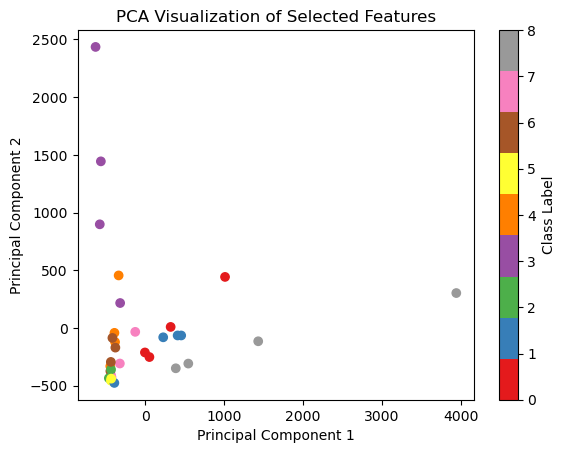

In [32]:
from sklearn.decomposition import PCA

n_components = 2
pca = PCA(n_components=n_components)
X_train_pca = pca.fit_transform(X_train)

# Scatter plot
plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=encoded_labels, cmap="Set1")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title("PCA Visualization of Selected Features")
plt.colorbar(label="Class Label")
plt.show()

In [14]:
y_train = pd.get_dummies(y_train, dtype=int)
y_test = pd.get_dummies(y_test, dtype=int)

## 4. Build an architecture from scratch or choose a pretrained model

In [26]:
keras.backend.clear_session()
keras.utils.set_random_seed(2)
WANDB_NOTEBOOK_NAME = "20230907 comparison with MLPC.ipynb"

In [16]:
run = wandb.init(project="NN-MATSeq")

model_at = use_artifact(
    "afanasyeva-team/NN-MATseq/model-glorious-sweep-34:v19", type="model"
)

model_dir = model_at.download()
print("model: ", model_dir)
model = keras.models.load_model(model_dir)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: Currently logged in as: afanasyeva-tess (afanasyeva-team). Use `wandb login --relogin` to force relogin
cat: /sys/module/amdgpu/initstate: No such file or directory
ERROR:root:Driver not initialized (amdgpu not found in modules)


wandb:   5 of 5 files downloaded.  


model:  ./artifacts/model-glorious-sweep-34:v19


2023-09-07 16:46:22.955224: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13775 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:3b:00.0, compute capability: 7.5


In [18]:
y_pred = model.predict(X_test)

1/1 [==============================] - 4s 4s/step


In [19]:
prediction = pd.DataFrame(y_pred, columns=y_test.columns)
prediction.head()

,CL-307,CRX-527,Fla-PA,IMDM,LPS,LTA,PGN,Pam3,R848
0,0.054136,0.062996,0.090928,0.138935,0.271246,0.056321,0.094588,0.194286,0.036563
1,0.228503,0.083238,0.062761,0.032527,0.039934,0.082519,0.021815,0.078525,0.370177
2,0.050906,0.050100,0.084057,0.170601,0.278248,0.057776,0.144415,0.127747,0.036150
3,0.122007,0.166115,0.105753,0.060111,0.108220,0.124065,0.033402,0.162575,0.117754
4,0.037382,0.028038,0.049291,0.268621,0.347486,0.040901,0.099763,0.111715,0.016803


In [20]:
predicted_species = prediction.idxmax(axis="columns")
true_species = y_test.idxmax(axis="columns")

<Axes: >

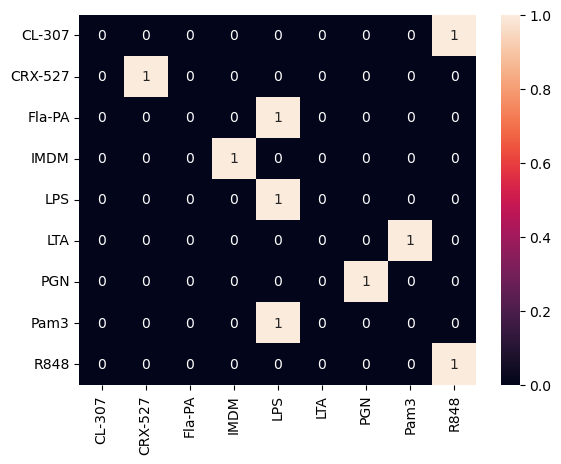

In [21]:
from sklearn.metrics import confusion_matrix

matrix = confusion_matrix(true_species, predicted_species)

confusion_df = pd.DataFrame(
    matrix, index=y_test.columns.values, columns=y_test.columns.values
)

sns.heatmap(confusion_df, annot=True)

In [18]:
from sklearn import metrics

statistics_dict = {}


def evaluate_model(name, real_labels, predicted_labels):
    accuracy, precision, recall, specificity, f1_score, confusion_matrix = (
        metrics.accuracy_score(real_labels, predicted_labels),
        metrics.precision_score(
            real_labels, predicted_labels, average="macro", zero_division=0
        ),
        metrics.recall_score(real_labels, predicted_labels, average="macro"),
        metrics.recall_score(real_labels, predicted_labels, average="macro"),
        metrics.f1_score(real_labels, predicted_labels, average="macro"),
        metrics.confusion_matrix(real_labels, predicted_labels),
    )
    statistics_dict[name] = {
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "Specificity": specificity,
        "F1 Score": f1_score,
        "Confusion Matrix": confusion_matrix,
    }
    return statistics_dict

In [23]:
evaluate_model("MATseq_NN_multiclass_classifier", true_species, predicted_species)

{'MATseq_NN_multiclass_classifier': {'Accuracy': 0.5555555555555556,
  'Precision': 0.4259259259259259,
  'Recall': 0.5555555555555556,
  'Specificity': 0.5555555555555556,
  'F1 Score': 0.462962962962963,
  'Confusion Matrix': array([[0, 0, 0, 0, 0, 0, 0, 0, 1],
         [0, 1, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 1, 0, 0, 0, 0],
         [0, 0, 0, 1, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 1, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 1, 0],
         [0, 0, 0, 0, 0, 0, 1, 0, 0],
         [0, 0, 0, 0, 1, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0, 1]])}}

In [25]:
 finish()

wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Model does not perform as well as during the sweep. I will try to train it using the sweeps parameters.

In [27]:
default_config = {
    "l1": 32,
    "l2": 24,
    "batch_size": 12,
    "activation": "relu",
    "weights_limit": 0.001,
    "epochs": 320,
    "learning_rate": 0.002,
    "loss": "categorical_crossentropy",
    "optimizer": "adam",
    "dropout_rate1": 0.1,
    "dropout_rate2": 0.2,
}

In [29]:
early_stop = keras.callbacks.EarlyStopping(monitor="loss", patience=3)

In [30]:
def train():
    with tf.device("GPU:0"):
        with wandb.init(project="NN-MATseq", config=default_config) as run:
            batch_size = run.config.batch_size
            activation = run.config.activation
            weights_limit = run.config.weights_limit
            epochs = run.config.epochs
            learning_rate = run.config.learning_rate
            loss = run.config.loss
            l1 = run.config.l1
            l2 = run.config.l2
            dropout_rate1 = run.config.dropout_rate1
            dropout_rate2 = run.config.dropout_rate2

            if run.config.optimizer == "adam":
                optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
            elif run.config.optimizer == "sgd":
                optimizer = keras.optimizers.SGD(learning_rate=learning_rate)
            elif run.config.optimizer == "rmsprop":
                optimizer = keras.optimizers.RMSprop(learning_rate=learning_rate)

            inputs = keras.Input(shape=X_train.shape[1])
            x = keras.layers.UnitNormalization()(inputs)

            x = keras.layers.Dense(
                l1,
                activation=activation,
                kernel_regularizer=keras.regularizers.L2(weights_limit),
            )(x)
            x = keras.layers.Dropout(dropout_rate1)(x)

            x = keras.layers.Dense(
                l2,
                activation=activation,
                kernel_regularizer=keras.regularizers.L2(weights_limit),
            )(x)
            x = keras.layers.Dropout(dropout_rate2)(x)

            outputs = keras.layers.Dense(9, activation="softmax")(x)

            model = keras.Model(
                inputs=inputs, outputs=outputs, name="NN_multiclass_classifier_MATseq"
            )

            model.compile(
                optimizer=optimizer,
                loss=loss,
                metrics=[
                    "accuracy",
                    keras.metrics.AUC(name="auc"),
                ],
            )

            history = model.fit(
                X_train,
                y_train,
                validation_data=(X_test, y_test),
                epochs=epochs,
                batch_size=batch_size,
                verbose=True,
                callbacks=[wandb.keras.WandbCallback()],
            )

            model.save("MATseq_NN_multiclass_classifier.keras", overwrite=True)

In [33]:
model = train()

cat: /sys/module/amdgpu/initstate: No such file or directory
ERROR:root:Driver not initialized (amdgpu not found in modules)


wandb: WARNING The save_model argument by default saves the model in the HDF5 format that cannot save custom objects like subclassed models and custom layers. This behavior will be deprecated in a future release in favor of the SavedModel format. Meanwhile, the HDF5 model is saved as W&B files and the SavedModel as W&B Artifacts.


Epoch 1/320


2023-09-07 17:02:43.318563: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x55d72ee9bd80 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-09-07 17:02:43.318622: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
2023-09-07 17:02:43.712594: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-09-07 17:02:44.621464: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600
2023-09-07 17:02:45.409065: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1/3 [=========>....................] - ETA: 7s - loss: 2.2794 - accuracy: 0.2500 - auc: 0.4900

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230907_170236-xucn8aqs/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230907_170236-xucn8aqs/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230907_170236-xucn8aqs/files/model-best)... Done. 0.0s


3/3 [==============================] - 5s 703ms/step - loss: 2.2776 - accuracy: 0.1875 - auc: 0.4931 - val_loss: 2.2758 - val_accuracy: 0.2222 - val_auc: 0.4977
Epoch 2/320
1/3 [=========>....................] - ETA: 0s - loss: 2.2563 - accuracy: 0.2500 - auc: 0.6228

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230907_170236-xucn8aqs/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230907_170236-xucn8aqs/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230907_170236-xucn8aqs/files/model-best)... Done. 0.0s


3/3 [==============================] - 1s 384ms/step - loss: 2.2524 - accuracy: 0.2500 - auc: 0.6381 - val_loss: 2.2665 - val_accuracy: 0.2222 - val_auc: 0.5347
Epoch 3/320
1/3 [=========>....................] - ETA: 0s - loss: 2.2659 - accuracy: 0.0833 - auc: 0.5764

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230907_170236-xucn8aqs/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230907_170236-xucn8aqs/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230907_170236-xucn8aqs/files/model-best)... Done. 0.0s


3/3 [==============================] - 1s 382ms/step - loss: 2.2354 - accuracy: 0.2812 - auc: 0.6613 - val_loss: 2.2575 - val_accuracy: 0.2222 - val_auc: 0.5123
Epoch 4/320
1/3 [=========>....................] - ETA: 0s - loss: 2.2078 - accuracy: 0.2500 - auc: 0.7261

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230907_170236-xucn8aqs/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230907_170236-xucn8aqs/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230907_170236-xucn8aqs/files/model-best)... Done. 0.0s


3/3 [==============================] - 1s 376ms/step - loss: 2.2069 - accuracy: 0.2500 - auc: 0.7189 - val_loss: 2.2470 - val_accuracy: 0.2222 - val_auc: 0.5509
Epoch 5/320
1/3 [=========>....................] - ETA: 0s - loss: 2.1697 - accuracy: 0.3333 - auc: 0.7947

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230907_170236-xucn8aqs/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230907_170236-xucn8aqs/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230907_170236-xucn8aqs/files/model-best)... Done. 0.0s


3/3 [==============================] - 1s 388ms/step - loss: 2.1889 - accuracy: 0.2812 - auc: 0.7213 - val_loss: 2.2344 - val_accuracy: 0.2222 - val_auc: 0.5556
Epoch 6/320
1/3 [=========>....................] - ETA: 0s - loss: 2.1725 - accuracy: 0.0833 - auc: 0.7135

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230907_170236-xucn8aqs/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230907_170236-xucn8aqs/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230907_170236-xucn8aqs/files/model-best)... Done. 0.0s


3/3 [==============================] - 1s 395ms/step - loss: 2.1478 - accuracy: 0.3750 - auc: 0.7462 - val_loss: 2.2166 - val_accuracy: 0.3333 - val_auc: 0.6011
Epoch 7/320
1/3 [=========>....................] - ETA: 0s - loss: 2.1365 - accuracy: 0.4167 - auc: 0.7144

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230907_170236-xucn8aqs/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230907_170236-xucn8aqs/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230907_170236-xucn8aqs/files/model-best)... Done. 0.0s


3/3 [==============================] - 1s 388ms/step - loss: 2.1137 - accuracy: 0.2812 - auc: 0.7612 - val_loss: 2.1895 - val_accuracy: 0.3333 - val_auc: 0.6427
Epoch 8/320
1/3 [=========>....................] - ETA: 0s - loss: 2.0266 - accuracy: 0.5000 - auc: 0.8876

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230907_170236-xucn8aqs/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230907_170236-xucn8aqs/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230907_170236-xucn8aqs/files/model-best)... Done. 0.0s


3/3 [==============================] - 1s 392ms/step - loss: 2.0860 - accuracy: 0.3125 - auc: 0.8169 - val_loss: 2.1587 - val_accuracy: 0.3333 - val_auc: 0.6752
Epoch 9/320
1/3 [=========>....................] - ETA: 0s - loss: 2.0606 - accuracy: 0.3333 - auc: 0.8464

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230907_170236-xucn8aqs/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230907_170236-xucn8aqs/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230907_170236-xucn8aqs/files/model-best)... Done. 0.0s


3/3 [==============================] - 1s 390ms/step - loss: 2.0263 - accuracy: 0.4062 - auc: 0.8467 - val_loss: 2.1281 - val_accuracy: 0.3333 - val_auc: 0.6983
Epoch 10/320
1/3 [=========>....................] - ETA: 0s - loss: 2.0378 - accuracy: 0.2500 - auc: 0.8134

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230907_170236-xucn8aqs/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230907_170236-xucn8aqs/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230907_170236-xucn8aqs/files/model-best)... Done. 0.0s


3/3 [==============================] - 1s 510ms/step - loss: 2.0121 - accuracy: 0.4688 - auc: 0.8384 - val_loss: 2.1033 - val_accuracy: 0.3333 - val_auc: 0.6991
Epoch 11/320
1/3 [=========>....................] - ETA: 0s - loss: 1.9158 - accuracy: 0.5833 - auc: 0.8602

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230907_170236-xucn8aqs/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230907_170236-xucn8aqs/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230907_170236-xucn8aqs/files/model-best)... Done. 0.0s


3/3 [==============================] - 1s 393ms/step - loss: 1.9665 - accuracy: 0.5312 - auc: 0.8554 - val_loss: 2.0722 - val_accuracy: 0.3333 - val_auc: 0.7130
Epoch 12/320
1/3 [=========>....................] - ETA: 0s - loss: 1.9072 - accuracy: 0.5000 - auc: 0.8976

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230907_170236-xucn8aqs/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230907_170236-xucn8aqs/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230907_170236-xucn8aqs/files/model-best)... Done. 0.0s


3/3 [==============================] - 1s 403ms/step - loss: 1.8578 - accuracy: 0.5625 - auc: 0.8854 - val_loss: 2.0413 - val_accuracy: 0.2222 - val_auc: 0.7299
Epoch 13/320
1/3 [=========>....................] - ETA: 0s - loss: 1.8172 - accuracy: 0.5000 - auc: 0.8989

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230907_170236-xucn8aqs/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230907_170236-xucn8aqs/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230907_170236-xucn8aqs/files/model-best)... Done. 0.0s


3/3 [==============================] - 1s 388ms/step - loss: 1.8380 - accuracy: 0.5312 - auc: 0.8938 - val_loss: 2.0026 - val_accuracy: 0.2222 - val_auc: 0.7469
Epoch 14/320
1/3 [=========>....................] - ETA: 0s - loss: 1.7982 - accuracy: 0.5833 - auc: 0.9154

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230907_170236-xucn8aqs/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230907_170236-xucn8aqs/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230907_170236-xucn8aqs/files/model-best)... Done. 0.0s


3/3 [==============================] - 1s 390ms/step - loss: 1.7136 - accuracy: 0.7188 - auc: 0.9406 - val_loss: 1.9634 - val_accuracy: 0.2222 - val_auc: 0.7608
Epoch 15/320
1/3 [=========>....................] - ETA: 0s - loss: 1.7983 - accuracy: 0.5833 - auc: 0.8711

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230907_170236-xucn8aqs/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230907_170236-xucn8aqs/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230907_170236-xucn8aqs/files/model-best)... Done. 0.0s


3/3 [==============================] - 1s 387ms/step - loss: 1.7743 - accuracy: 0.5625 - auc: 0.8950 - val_loss: 1.9311 - val_accuracy: 0.2222 - val_auc: 0.7670
Epoch 16/320
1/3 [=========>....................] - ETA: 0s - loss: 1.5197 - accuracy: 0.9167 - auc: 0.9844

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230907_170236-xucn8aqs/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230907_170236-xucn8aqs/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230907_170236-xucn8aqs/files/model-best)... Done. 0.0s


3/3 [==============================] - 1s 390ms/step - loss: 1.6447 - accuracy: 0.7500 - auc: 0.9227 - val_loss: 1.8961 - val_accuracy: 0.3333 - val_auc: 0.7747
Epoch 17/320
1/3 [=========>....................] - ETA: 0s - loss: 1.6884 - accuracy: 0.5000 - auc: 0.9080

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230907_170236-xucn8aqs/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230907_170236-xucn8aqs/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230907_170236-xucn8aqs/files/model-best)... Done. 0.0s


3/3 [==============================] - 1s 388ms/step - loss: 1.6001 - accuracy: 0.6875 - auc: 0.9319 - val_loss: 1.8468 - val_accuracy: 0.4444 - val_auc: 0.7932
Epoch 18/320
1/3 [=========>....................] - ETA: 0s - loss: 1.5636 - accuracy: 0.6667 - auc: 0.9449

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230907_170236-xucn8aqs/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230907_170236-xucn8aqs/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230907_170236-xucn8aqs/files/model-best)... Done. 0.0s


3/3 [==============================] - 1s 407ms/step - loss: 1.5704 - accuracy: 0.6250 - auc: 0.9391 - val_loss: 1.7925 - val_accuracy: 0.4444 - val_auc: 0.8117
Epoch 19/320
1/3 [=========>....................] - ETA: 0s - loss: 1.2972 - accuracy: 0.9167 - auc: 0.9809

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230907_170236-xucn8aqs/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230907_170236-xucn8aqs/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230907_170236-xucn8aqs/files/model-best)... Done. 0.0s


3/3 [==============================] - 1s 510ms/step - loss: 1.4366 - accuracy: 0.8125 - auc: 0.9580 - val_loss: 1.7550 - val_accuracy: 0.4444 - val_auc: 0.8218
Epoch 20/320
1/3 [=========>....................] - ETA: 0s - loss: 1.2545 - accuracy: 0.8333 - auc: 0.9787

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230907_170236-xucn8aqs/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230907_170236-xucn8aqs/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230907_170236-xucn8aqs/files/model-best)... Done. 0.0s


3/3 [==============================] - 1s 395ms/step - loss: 1.3517 - accuracy: 0.7812 - auc: 0.9616 - val_loss: 1.7034 - val_accuracy: 0.4444 - val_auc: 0.8418
Epoch 21/320
1/3 [=========>....................] - ETA: 0s - loss: 1.4679 - accuracy: 0.5833 - auc: 0.9440

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230907_170236-xucn8aqs/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230907_170236-xucn8aqs/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230907_170236-xucn8aqs/files/model-best)... Done. 0.0s


3/3 [==============================] - 1s 415ms/step - loss: 1.4099 - accuracy: 0.6250 - auc: 0.9559 - val_loss: 1.6478 - val_accuracy: 0.5556 - val_auc: 0.8634
Epoch 22/320
1/3 [=========>....................] - ETA: 0s - loss: 1.4619 - accuracy: 0.5833 - auc: 0.9345

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230907_170236-xucn8aqs/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230907_170236-xucn8aqs/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230907_170236-xucn8aqs/files/model-best)... Done. 0.0s


3/3 [==============================] - 1s 394ms/step - loss: 1.3150 - accuracy: 0.6875 - auc: 0.9540 - val_loss: 1.5905 - val_accuracy: 0.5556 - val_auc: 0.8881
Epoch 23/320
1/3 [=========>....................] - ETA: 0s - loss: 1.1229 - accuracy: 0.8333 - auc: 0.9852

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230907_170236-xucn8aqs/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230907_170236-xucn8aqs/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230907_170236-xucn8aqs/files/model-best)... Done. 0.0s


3/3 [==============================] - 1s 391ms/step - loss: 1.3348 - accuracy: 0.6250 - auc: 0.9612 - val_loss: 1.5466 - val_accuracy: 0.5556 - val_auc: 0.8981
Epoch 24/320
1/3 [=========>....................] - ETA: 0s - loss: 1.2095 - accuracy: 0.9167 - auc: 0.9900

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230907_170236-xucn8aqs/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230907_170236-xucn8aqs/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230907_170236-xucn8aqs/files/model-best)... Done. 0.0s


3/3 [==============================] - 1s 397ms/step - loss: 1.1896 - accuracy: 0.9062 - auc: 0.9825 - val_loss: 1.5118 - val_accuracy: 0.5556 - val_auc: 0.8951
Epoch 25/320
1/3 [=========>....................] - ETA: 0s - loss: 1.0449 - accuracy: 0.8333 - auc: 0.9857

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230907_170236-xucn8aqs/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230907_170236-xucn8aqs/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230907_170236-xucn8aqs/files/model-best)... Done. 0.0s


3/3 [==============================] - 1s 385ms/step - loss: 1.0888 - accuracy: 0.8438 - auc: 0.9841 - val_loss: 1.4902 - val_accuracy: 0.6667 - val_auc: 0.8935
Epoch 26/320
1/3 [=========>....................] - ETA: 0s - loss: 1.0024 - accuracy: 0.8333 - auc: 0.9848

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230907_170236-xucn8aqs/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230907_170236-xucn8aqs/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230907_170236-xucn8aqs/files/model-best)... Done. 0.0s


3/3 [==============================] - 1s 386ms/step - loss: 1.1023 - accuracy: 0.7500 - auc: 0.9700 - val_loss: 1.4674 - val_accuracy: 0.6667 - val_auc: 0.8912
Epoch 27/320
1/3 [=========>....................] - ETA: 0s - loss: 0.8814 - accuracy: 0.8333 - auc: 0.9961

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230907_170236-xucn8aqs/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230907_170236-xucn8aqs/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230907_170236-xucn8aqs/files/model-best)... Done. 0.0s


3/3 [==============================] - 1s 445ms/step - loss: 1.0203 - accuracy: 0.7812 - auc: 0.9789 - val_loss: 1.4188 - val_accuracy: 0.6667 - val_auc: 0.9128
Epoch 28/320
1/3 [=========>....................] - ETA: 0s - loss: 1.0747 - accuracy: 0.8333 - auc: 0.9805

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230907_170236-xucn8aqs/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230907_170236-xucn8aqs/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230907_170236-xucn8aqs/files/model-best)... Done. 0.0s


3/3 [==============================] - 1s 399ms/step - loss: 0.9991 - accuracy: 0.7500 - auc: 0.9785 - val_loss: 1.3789 - val_accuracy: 0.6667 - val_auc: 0.9151
Epoch 29/320
1/3 [=========>....................] - ETA: 0s - loss: 0.9680 - accuracy: 0.7500 - auc: 0.9813

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230907_170236-xucn8aqs/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230907_170236-xucn8aqs/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230907_170236-xucn8aqs/files/model-best)... Done. 0.0s


3/3 [==============================] - 1s 524ms/step - loss: 0.8857 - accuracy: 0.7812 - auc: 0.9862 - val_loss: 1.3393 - val_accuracy: 0.6667 - val_auc: 0.9244
Epoch 30/320
1/3 [=========>....................] - ETA: 0s - loss: 0.7236 - accuracy: 1.0000 - auc: 0.9983

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230907_170236-xucn8aqs/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230907_170236-xucn8aqs/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230907_170236-xucn8aqs/files/model-best)... Done. 0.0s


3/3 [==============================] - 1s 387ms/step - loss: 0.9175 - accuracy: 0.9375 - auc: 0.9910 - val_loss: 1.3125 - val_accuracy: 0.6667 - val_auc: 0.9267
Epoch 31/320
1/3 [=========>....................] - ETA: 0s - loss: 0.6275 - accuracy: 1.0000 - auc: 0.9991

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230907_170236-xucn8aqs/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230907_170236-xucn8aqs/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230907_170236-xucn8aqs/files/model-best)... Done. 0.0s


3/3 [==============================] - 1s 414ms/step - loss: 0.8789 - accuracy: 0.9375 - auc: 0.9890 - val_loss: 1.2815 - val_accuracy: 0.6667 - val_auc: 0.9298
Epoch 32/320
1/3 [=========>....................] - ETA: 0s - loss: 0.7754 - accuracy: 0.9167 - auc: 0.9944

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230907_170236-xucn8aqs/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230907_170236-xucn8aqs/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230907_170236-xucn8aqs/files/model-best)... Done. 0.0s


3/3 [==============================] - 1s 384ms/step - loss: 0.7715 - accuracy: 0.9062 - auc: 0.9938 - val_loss: 1.2510 - val_accuracy: 0.6667 - val_auc: 0.9390
Epoch 33/320
1/3 [=========>....................] - ETA: 0s - loss: 1.0134 - accuracy: 0.7500 - auc: 0.9822

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230907_170236-xucn8aqs/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230907_170236-xucn8aqs/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230907_170236-xucn8aqs/files/model-best)... Done. 0.0s


3/3 [==============================] - 1s 396ms/step - loss: 0.8902 - accuracy: 0.7500 - auc: 0.9850 - val_loss: 1.2065 - val_accuracy: 0.6667 - val_auc: 0.9475
Epoch 34/320
1/3 [=========>....................] - ETA: 0s - loss: 0.7672 - accuracy: 0.7500 - auc: 0.9931

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230907_170236-xucn8aqs/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230907_170236-xucn8aqs/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230907_170236-xucn8aqs/files/model-best)... Done. 0.0s


3/3 [==============================] - 1s 387ms/step - loss: 0.7118 - accuracy: 0.8438 - auc: 0.9949 - val_loss: 1.1676 - val_accuracy: 0.7778 - val_auc: 0.9545
Epoch 35/320
1/3 [=========>....................] - ETA: 0s - loss: 0.6688 - accuracy: 1.0000 - auc: 0.9983

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230907_170236-xucn8aqs/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230907_170236-xucn8aqs/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230907_170236-xucn8aqs/files/model-best)... Done. 0.0s


3/3 [==============================] - 1s 386ms/step - loss: 0.7560 - accuracy: 0.9375 - auc: 0.9926 - val_loss: 1.1471 - val_accuracy: 0.6667 - val_auc: 0.9545
Epoch 36/320
1/3 [=========>....................] - ETA: 0s - loss: 0.8606 - accuracy: 0.7500 - auc: 0.9800

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230907_170236-xucn8aqs/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230907_170236-xucn8aqs/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230907_170236-xucn8aqs/files/model-best)... Done. 0.0s


3/3 [==============================] - 1s 392ms/step - loss: 0.7796 - accuracy: 0.8125 - auc: 0.9866 - val_loss: 1.1306 - val_accuracy: 0.6667 - val_auc: 0.9560
Epoch 37/320
1/3 [=========>....................] - ETA: 0s - loss: 0.8484 - accuracy: 0.8333 - auc: 0.9891

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230907_170236-xucn8aqs/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230907_170236-xucn8aqs/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230907_170236-xucn8aqs/files/model-best)... Done. 0.0s


3/3 [==============================] - 1s 376ms/step - loss: 0.6777 - accuracy: 0.8750 - auc: 0.9938 - val_loss: 1.1135 - val_accuracy: 0.7778 - val_auc: 0.9591
Epoch 38/320
1/3 [=========>....................] - ETA: 0s - loss: 0.4124 - accuracy: 0.9167 - auc: 0.9991

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230907_170236-xucn8aqs/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230907_170236-xucn8aqs/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230907_170236-xucn8aqs/files/model-best)... Done. 0.0s


3/3 [==============================] - 1s 395ms/step - loss: 0.5251 - accuracy: 0.9062 - auc: 0.9984 - val_loss: 1.1079 - val_accuracy: 0.7778 - val_auc: 0.9568
Epoch 39/320
3/3 [==============================] - 0s 26ms/step - loss: 0.6049 - accuracy: 0.9375 - auc: 0.9971 - val_loss: 1.1115 - val_accuracy: 0.7778 - val_auc: 0.9545
Epoch 40/320
1/3 [=========>....................] - ETA: 0s - loss: 0.7626 - accuracy: 0.8333 - auc: 0.9922

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230907_170236-xucn8aqs/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230907_170236-xucn8aqs/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230907_170236-xucn8aqs/files/model-best)... Done. 0.0s


3/3 [==============================] - 1s 546ms/step - loss: 0.6381 - accuracy: 0.8750 - auc: 0.9946 - val_loss: 1.0821 - val_accuracy: 0.7778 - val_auc: 0.9552
Epoch 41/320
1/3 [=========>....................] - ETA: 0s - loss: 0.4697 - accuracy: 1.0000 - auc: 1.0000

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230907_170236-xucn8aqs/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230907_170236-xucn8aqs/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230907_170236-xucn8aqs/files/model-best)... Done. 0.0s


3/3 [==============================] - 1s 399ms/step - loss: 0.5194 - accuracy: 0.9688 - auc: 0.9980 - val_loss: 1.0328 - val_accuracy: 0.7778 - val_auc: 0.9560
Epoch 42/320
1/3 [=========>....................] - ETA: 0s - loss: 0.4268 - accuracy: 1.0000 - auc: 1.0000

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230907_170236-xucn8aqs/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230907_170236-xucn8aqs/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230907_170236-xucn8aqs/files/model-best)... Done. 0.0s


3/3 [==============================] - 1s 394ms/step - loss: 0.5038 - accuracy: 1.0000 - auc: 0.9999 - val_loss: 0.9967 - val_accuracy: 0.7778 - val_auc: 0.9576
Epoch 43/320
1/3 [=========>....................] - ETA: 0s - loss: 0.6489 - accuracy: 0.8333 - auc: 0.9935

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230907_170236-xucn8aqs/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230907_170236-xucn8aqs/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230907_170236-xucn8aqs/files/model-best)... Done. 0.0s


3/3 [==============================] - 1s 381ms/step - loss: 0.5872 - accuracy: 0.8438 - auc: 0.9930 - val_loss: 0.9833 - val_accuracy: 0.7778 - val_auc: 0.9599
Epoch 44/320
3/3 [==============================] - 0s 25ms/step - loss: 0.5313 - accuracy: 0.9062 - auc: 0.9969 - val_loss: 0.9835 - val_accuracy: 0.7778 - val_auc: 0.9583
Epoch 45/320
1/3 [=========>....................] - ETA: 0s - loss: 0.4179 - accuracy: 0.9167 - auc: 0.9991

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230907_170236-xucn8aqs/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230907_170236-xucn8aqs/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230907_170236-xucn8aqs/files/model-best)... Done. 0.0s


3/3 [==============================] - 1s 387ms/step - loss: 0.4419 - accuracy: 0.9375 - auc: 0.9989 - val_loss: 0.9800 - val_accuracy: 0.7778 - val_auc: 0.9583
Epoch 46/320
1/3 [=========>....................] - ETA: 0s - loss: 0.4799 - accuracy: 1.0000 - auc: 1.0000

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230907_170236-xucn8aqs/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230907_170236-xucn8aqs/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230907_170236-xucn8aqs/files/model-best)... Done. 0.0s


3/3 [==============================] - 1s 385ms/step - loss: 0.5119 - accuracy: 0.9375 - auc: 0.9972 - val_loss: 0.9667 - val_accuracy: 0.7778 - val_auc: 0.9591
Epoch 47/320
1/3 [=========>....................] - ETA: 0s - loss: 0.4067 - accuracy: 1.0000 - auc: 1.0000

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230907_170236-xucn8aqs/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230907_170236-xucn8aqs/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230907_170236-xucn8aqs/files/model-best)... Done. 0.0s


3/3 [==============================] - 1s 387ms/step - loss: 0.4171 - accuracy: 0.9375 - auc: 0.9996 - val_loss: 0.9339 - val_accuracy: 0.7778 - val_auc: 0.9645
Epoch 48/320
1/3 [=========>....................] - ETA: 0s - loss: 0.4837 - accuracy: 0.8333 - auc: 0.9965

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230907_170236-xucn8aqs/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230907_170236-xucn8aqs/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230907_170236-xucn8aqs/files/model-best)... Done. 0.0s


3/3 [==============================] - 1s 392ms/step - loss: 0.5137 - accuracy: 0.9062 - auc: 0.9981 - val_loss: 0.9140 - val_accuracy: 0.7778 - val_auc: 0.9738
Epoch 49/320
1/3 [=========>....................] - ETA: 0s - loss: 0.6310 - accuracy: 0.9167 - auc: 0.9957

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230907_170236-xucn8aqs/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230907_170236-xucn8aqs/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230907_170236-xucn8aqs/files/model-best)... Done. 0.0s


3/3 [==============================] - 1s 381ms/step - loss: 0.5154 - accuracy: 0.9375 - auc: 0.9985 - val_loss: 0.9038 - val_accuracy: 0.7778 - val_auc: 0.9730
Epoch 50/320
1/3 [=========>....................] - ETA: 0s - loss: 0.5453 - accuracy: 1.0000 - auc: 1.0000

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230907_170236-xucn8aqs/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230907_170236-xucn8aqs/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230907_170236-xucn8aqs/files/model-best)... Done. 0.0s


3/3 [==============================] - 1s 390ms/step - loss: 0.4988 - accuracy: 1.0000 - auc: 0.9998 - val_loss: 0.8983 - val_accuracy: 0.7778 - val_auc: 0.9722
Epoch 51/320
1/3 [=========>....................] - ETA: 0s - loss: 0.7999 - accuracy: 0.7500 - auc: 0.9809

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230907_170236-xucn8aqs/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230907_170236-xucn8aqs/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230907_170236-xucn8aqs/files/model-best)... Done. 0.0s


3/3 [==============================] - 1s 383ms/step - loss: 0.5451 - accuracy: 0.9062 - auc: 0.9951 - val_loss: 0.8927 - val_accuracy: 0.7778 - val_auc: 0.9707
Epoch 52/320
3/3 [==============================] - 0s 26ms/step - loss: 0.4415 - accuracy: 1.0000 - auc: 0.9996 - val_loss: 0.8928 - val_accuracy: 0.7778 - val_auc: 0.9699
Epoch 53/320
3/3 [==============================] - 0s 25ms/step - loss: 0.3953 - accuracy: 0.9688 - auc: 0.9994 - val_loss: 0.8994 - val_accuracy: 0.7778 - val_auc: 0.9645
Epoch 54/320
3/3 [==============================] - 0s 27ms/step - loss: 0.4233 - accuracy: 0.9375 - auc: 0.9985 - val_loss: 0.8937 - val_accuracy: 0.7778 - val_auc: 0.9668
Epoch 55/320
1/3 [=========>....................] - ETA: 0s - loss: 0.4043 - accuracy: 1.0000 - auc: 1.0000

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230907_170236-xucn8aqs/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230907_170236-xucn8aqs/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230907_170236-xucn8aqs/files/model-best)... Done. 0.0s


3/3 [==============================] - 1s 529ms/step - loss: 0.3941 - accuracy: 1.0000 - auc: 1.0000 - val_loss: 0.8845 - val_accuracy: 0.7778 - val_auc: 0.9699
Epoch 56/320
1/3 [=========>....................] - ETA: 0s - loss: 0.3852 - accuracy: 0.9167 - auc: 0.9991

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230907_170236-xucn8aqs/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230907_170236-xucn8aqs/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230907_170236-xucn8aqs/files/model-best)... Done. 0.0s


3/3 [==============================] - 1s 400ms/step - loss: 0.3952 - accuracy: 0.9375 - auc: 0.9994 - val_loss: 0.8790 - val_accuracy: 0.7778 - val_auc: 0.9676
Epoch 57/320
3/3 [==============================] - 0s 28ms/step - loss: 0.3631 - accuracy: 0.9375 - auc: 0.9990 - val_loss: 0.8796 - val_accuracy: 0.7778 - val_auc: 0.9699
Epoch 58/320
3/3 [==============================] - 0s 26ms/step - loss: 0.4023 - accuracy: 1.0000 - auc: 1.0000 - val_loss: 0.8793 - val_accuracy: 0.7778 - val_auc: 0.9699
Epoch 59/320
3/3 [==============================] - 0s 26ms/step - loss: 0.5028 - accuracy: 0.9375 - auc: 0.9976 - val_loss: 0.8865 - val_accuracy: 0.7778 - val_auc: 0.9699
Epoch 60/320
1/3 [=========>....................] - ETA: 0s - loss: 0.3223 - accuracy: 1.0000 - auc: 1.0000

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230907_170236-xucn8aqs/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230907_170236-xucn8aqs/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230907_170236-xucn8aqs/files/model-best)... Done. 0.0s


3/3 [==============================] - 1s 382ms/step - loss: 0.3943 - accuracy: 1.0000 - auc: 0.9999 - val_loss: 0.8716 - val_accuracy: 0.7778 - val_auc: 0.9699
Epoch 61/320
1/3 [=========>....................] - ETA: 0s - loss: 0.3897 - accuracy: 0.9167 - auc: 0.9991

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230907_170236-xucn8aqs/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230907_170236-xucn8aqs/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230907_170236-xucn8aqs/files/model-best)... Done. 0.0s


3/3 [==============================] - 1s 384ms/step - loss: 0.3430 - accuracy: 0.9688 - auc: 0.9998 - val_loss: 0.8601 - val_accuracy: 0.7778 - val_auc: 0.9707
Epoch 62/320
1/3 [=========>....................] - ETA: 0s - loss: 0.4332 - accuracy: 0.9167 - auc: 0.9983

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230907_170236-xucn8aqs/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230907_170236-xucn8aqs/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230907_170236-xucn8aqs/files/model-best)... Done. 0.0s


3/3 [==============================] - 1s 384ms/step - loss: 0.3655 - accuracy: 0.9688 - auc: 0.9995 - val_loss: 0.8555 - val_accuracy: 0.7778 - val_auc: 0.9722
Epoch 63/320
3/3 [==============================] - 0s 25ms/step - loss: 0.3162 - accuracy: 1.0000 - auc: 1.0000 - val_loss: 0.8556 - val_accuracy: 0.7778 - val_auc: 0.9738
Epoch 64/320
3/3 [==============================] - 0s 26ms/step - loss: 0.4233 - accuracy: 0.9688 - auc: 0.9976 - val_loss: 0.8694 - val_accuracy: 0.7778 - val_auc: 0.9730
Epoch 65/320
3/3 [==============================] - 0s 27ms/step - loss: 0.3283 - accuracy: 0.9688 - auc: 0.9999 - val_loss: 0.8796 - val_accuracy: 0.7778 - val_auc: 0.9722
Epoch 66/320
3/3 [==============================] - 0s 26ms/step - loss: 0.3098 - accuracy: 1.0000 - auc: 1.0000 - val_loss: 0.8791 - val_accuracy: 0.7778 - val_auc: 0.9707
Epoch 67/320
3/3 [==============================] - 0s 28ms/step - loss: 0.3651 - accuracy: 1.0000 - auc: 0.9996 - val_loss: 0.8713 - val_accuracy:

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230907_170236-xucn8aqs/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230907_170236-xucn8aqs/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230907_170236-xucn8aqs/files/model-best)... Done. 0.0s


3/3 [==============================] - 1s 403ms/step - loss: 0.4471 - accuracy: 0.9062 - auc: 0.9977 - val_loss: 0.8511 - val_accuracy: 0.7778 - val_auc: 0.9730
Epoch 69/320
1/3 [=========>....................] - ETA: 0s - loss: 0.4474 - accuracy: 0.9167 - auc: 0.9974

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230907_170236-xucn8aqs/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230907_170236-xucn8aqs/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230907_170236-xucn8aqs/files/model-best)... Done. 0.0s


3/3 [==============================] - 1s 403ms/step - loss: 0.3559 - accuracy: 0.9688 - auc: 0.9995 - val_loss: 0.8353 - val_accuracy: 0.7778 - val_auc: 0.9745
Epoch 70/320
1/3 [=========>....................] - ETA: 0s - loss: 0.3069 - accuracy: 0.9167 - auc: 0.9991

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230907_170236-xucn8aqs/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230907_170236-xucn8aqs/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230907_170236-xucn8aqs/files/model-best)... Done. 0.0s


3/3 [==============================] - 1s 398ms/step - loss: 0.2846 - accuracy: 0.9688 - auc: 0.9999 - val_loss: 0.8222 - val_accuracy: 0.7778 - val_auc: 0.9745
Epoch 71/320
1/3 [=========>....................] - ETA: 0s - loss: 0.2732 - accuracy: 1.0000 - auc: 1.0000

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230907_170236-xucn8aqs/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230907_170236-xucn8aqs/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230907_170236-xucn8aqs/files/model-best)... Done. 0.0s


3/3 [==============================] - 1s 512ms/step - loss: 0.2852 - accuracy: 1.0000 - auc: 1.0000 - val_loss: 0.8096 - val_accuracy: 0.7778 - val_auc: 0.9745
Epoch 72/320
1/3 [=========>....................] - ETA: 0s - loss: 0.2737 - accuracy: 1.0000 - auc: 1.0000

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230907_170236-xucn8aqs/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230907_170236-xucn8aqs/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230907_170236-xucn8aqs/files/model-best)... Done. 0.0s


3/3 [==============================] - 1s 398ms/step - loss: 0.2757 - accuracy: 1.0000 - auc: 1.0000 - val_loss: 0.8040 - val_accuracy: 0.7778 - val_auc: 0.9753
Epoch 73/320
3/3 [==============================] - 0s 25ms/step - loss: 0.3084 - accuracy: 0.9688 - auc: 0.9999 - val_loss: 0.8076 - val_accuracy: 0.7778 - val_auc: 0.9730
Epoch 74/320
3/3 [==============================] - 0s 26ms/step - loss: 0.3154 - accuracy: 0.9688 - auc: 0.9998 - val_loss: 0.8078 - val_accuracy: 0.7778 - val_auc: 0.9745
Epoch 75/320
3/3 [==============================] - 0s 28ms/step - loss: 0.3635 - accuracy: 0.9375 - auc: 0.9992 - val_loss: 0.8176 - val_accuracy: 0.7778 - val_auc: 0.9738
Epoch 76/320
3/3 [==============================] - 0s 26ms/step - loss: 0.2645 - accuracy: 1.0000 - auc: 1.0000 - val_loss: 0.8395 - val_accuracy: 0.7778 - val_auc: 0.9722
Epoch 77/320
3/3 [==============================] - 0s 27ms/step - loss: 0.2999 - accuracy: 1.0000 - auc: 1.0000 - val_loss: 0.8676 - val_accuracy:

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230907_170236-xucn8aqs/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230907_170236-xucn8aqs/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230907_170236-xucn8aqs/files/model-best)... Done. 0.0s


3/3 [==============================] - 1s 385ms/step - loss: 0.2997 - accuracy: 0.9688 - auc: 0.9996 - val_loss: 0.7989 - val_accuracy: 0.7778 - val_auc: 0.9753
Epoch 86/320
3/3 [==============================] - 0s 25ms/step - loss: 0.2525 - accuracy: 1.0000 - auc: 1.0000 - val_loss: 0.8024 - val_accuracy: 0.7778 - val_auc: 0.9738
Epoch 87/320
3/3 [==============================] - 0s 26ms/step - loss: 0.4102 - accuracy: 0.9375 - auc: 0.9972 - val_loss: 0.8135 - val_accuracy: 0.7778 - val_auc: 0.9730
Epoch 88/320
3/3 [==============================] - 0s 26ms/step - loss: 0.2654 - accuracy: 1.0000 - auc: 1.0000 - val_loss: 0.8345 - val_accuracy: 0.7778 - val_auc: 0.9722
Epoch 89/320
3/3 [==============================] - 0s 25ms/step - loss: 0.2866 - accuracy: 1.0000 - auc: 0.9999 - val_loss: 0.8370 - val_accuracy: 0.7778 - val_auc: 0.9722
Epoch 90/320
3/3 [==============================] - 0s 26ms/step - loss: 0.2771 - accuracy: 1.0000 - auc: 1.0000 - val_loss: 0.8198 - val_accuracy:

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230907_170236-xucn8aqs/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230907_170236-xucn8aqs/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230907_170236-xucn8aqs/files/model-best)... Done. 0.0s


3/3 [==============================] - 1s 390ms/step - loss: 0.2337 - accuracy: 1.0000 - auc: 1.0000 - val_loss: 0.7911 - val_accuracy: 0.7778 - val_auc: 0.9761
Epoch 101/320
1/3 [=========>....................] - ETA: 0s - loss: 0.3104 - accuracy: 1.0000 - auc: 1.0000

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230907_170236-xucn8aqs/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230907_170236-xucn8aqs/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230907_170236-xucn8aqs/files/model-best)... Done. 0.0s


3/3 [==============================] - 1s 388ms/step - loss: 0.2665 - accuracy: 1.0000 - auc: 1.0000 - val_loss: 0.7753 - val_accuracy: 0.7778 - val_auc: 0.9769
Epoch 102/320
1/3 [=========>....................] - ETA: 0s - loss: 0.2305 - accuracy: 1.0000 - auc: 1.0000

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230907_170236-xucn8aqs/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230907_170236-xucn8aqs/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230907_170236-xucn8aqs/files/model-best)... Done. 0.0s


3/3 [==============================] - 1s 385ms/step - loss: 0.2557 - accuracy: 1.0000 - auc: 1.0000 - val_loss: 0.7591 - val_accuracy: 0.7778 - val_auc: 0.9784
Epoch 103/320
1/3 [=========>....................] - ETA: 0s - loss: 0.2027 - accuracy: 1.0000 - auc: 1.0000

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230907_170236-xucn8aqs/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230907_170236-xucn8aqs/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230907_170236-xucn8aqs/files/model-best)... Done. 0.0s


3/3 [==============================] - 1s 381ms/step - loss: 0.2236 - accuracy: 1.0000 - auc: 1.0000 - val_loss: 0.7441 - val_accuracy: 0.7778 - val_auc: 0.9799
Epoch 104/320
1/3 [=========>....................] - ETA: 0s - loss: 0.2324 - accuracy: 1.0000 - auc: 1.0000

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230907_170236-xucn8aqs/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230907_170236-xucn8aqs/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230907_170236-xucn8aqs/files/model-best)... Done. 0.0s


3/3 [==============================] - 1s 391ms/step - loss: 0.2706 - accuracy: 1.0000 - auc: 1.0000 - val_loss: 0.7379 - val_accuracy: 0.7778 - val_auc: 0.9799
Epoch 105/320
1/3 [=========>....................] - ETA: 0s - loss: 0.2778 - accuracy: 1.0000 - auc: 1.0000

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230907_170236-xucn8aqs/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230907_170236-xucn8aqs/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230907_170236-xucn8aqs/files/model-best)... Done. 0.0s


3/3 [==============================] - 1s 383ms/step - loss: 0.2885 - accuracy: 0.9688 - auc: 0.9998 - val_loss: 0.7308 - val_accuracy: 0.7778 - val_auc: 0.9799
Epoch 106/320
3/3 [==============================] - 0s 26ms/step - loss: 0.2676 - accuracy: 1.0000 - auc: 1.0000 - val_loss: 0.7372 - val_accuracy: 0.7778 - val_auc: 0.9799
Epoch 107/320
3/3 [==============================] - 0s 26ms/step - loss: 0.2137 - accuracy: 1.0000 - auc: 1.0000 - val_loss: 0.7558 - val_accuracy: 0.7778 - val_auc: 0.9792
Epoch 108/320
3/3 [==============================] - 0s 23ms/step - loss: 0.2390 - accuracy: 1.0000 - auc: 1.0000 - val_loss: 0.7716 - val_accuracy: 0.7778 - val_auc: 0.9776
Epoch 109/320
3/3 [==============================] - 0s 25ms/step - loss: 0.2478 - accuracy: 1.0000 - auc: 1.0000 - val_loss: 0.7861 - val_accuracy: 0.7778 - val_auc: 0.9769
Epoch 110/320
3/3 [==============================] - 0s 26ms/step - loss: 0.2077 - accuracy: 1.0000 - auc: 1.0000 - val_loss: 0.8035 - val_accu

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230907_170236-xucn8aqs/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230907_170236-xucn8aqs/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230907_170236-xucn8aqs/files/model-best)... Done. 0.0s


3/3 [==============================] - 1s 531ms/step - loss: 0.2064 - accuracy: 0.9688 - auc: 0.9999 - val_loss: 0.7163 - val_accuracy: 0.7778 - val_auc: 0.9784
Epoch 163/320
1/3 [=========>....................] - ETA: 0s - loss: 0.2353 - accuracy: 1.0000 - auc: 1.0000

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230907_170236-xucn8aqs/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230907_170236-xucn8aqs/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230907_170236-xucn8aqs/files/model-best)... Done. 0.0s


3/3 [==============================] - 1s 404ms/step - loss: 0.2105 - accuracy: 1.0000 - auc: 1.0000 - val_loss: 0.6889 - val_accuracy: 0.7778 - val_auc: 0.9799
Epoch 164/320
1/3 [=========>....................] - ETA: 0s - loss: 0.2421 - accuracy: 1.0000 - auc: 1.0000

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230907_170236-xucn8aqs/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230907_170236-xucn8aqs/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230907_170236-xucn8aqs/files/model-best)... Done. 0.0s


3/3 [==============================] - 1s 381ms/step - loss: 0.2342 - accuracy: 1.0000 - auc: 1.0000 - val_loss: 0.6792 - val_accuracy: 0.7778 - val_auc: 0.9799
Epoch 165/320
3/3 [==============================] - 0s 26ms/step - loss: 0.1890 - accuracy: 1.0000 - auc: 1.0000 - val_loss: 0.6798 - val_accuracy: 0.7778 - val_auc: 0.9815
Epoch 166/320
3/3 [==============================] - 0s 25ms/step - loss: 0.2014 - accuracy: 1.0000 - auc: 1.0000 - val_loss: 0.6989 - val_accuracy: 0.7778 - val_auc: 0.9799
Epoch 167/320
3/3 [==============================] - 0s 26ms/step - loss: 0.2233 - accuracy: 1.0000 - auc: 1.0000 - val_loss: 0.7180 - val_accuracy: 0.7778 - val_auc: 0.9799
Epoch 168/320
3/3 [==============================] - 0s 28ms/step - loss: 0.2141 - accuracy: 1.0000 - auc: 1.0000 - val_loss: 0.7312 - val_accuracy: 0.7778 - val_auc: 0.9799
Epoch 169/320
3/3 [==============================] - 0s 28ms/step - loss: 0.2279 - accuracy: 0.9688 - auc: 0.9998 - val_loss: 0.7304 - val_accu

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230907_170236-xucn8aqs/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230907_170236-xucn8aqs/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230907_170236-xucn8aqs/files/model-best)... Done. 0.0s


3/3 [==============================] - 1s 400ms/step - loss: 0.1729 - accuracy: 1.0000 - auc: 1.0000 - val_loss: 0.6686 - val_accuracy: 0.8889 - val_auc: 0.9776
Epoch 225/320
1/3 [=========>....................] - ETA: 0s - loss: 0.1416 - accuracy: 1.0000 - auc: 1.0000

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230907_170236-xucn8aqs/files/model-best/assets


INFO:tensorflow:Assets written to: /home/t.afanasyeva/MATseq/notebooks/wandb/run-20230907_170236-xucn8aqs/files/model-best/assets
wandb: Adding directory to artifact (/home/t.afanasyeva/MATseq/notebooks/wandb/run-20230907_170236-xucn8aqs/files/model-best)... Done. 0.0s


3/3 [==============================] - 1s 408ms/step - loss: 0.1535 - accuracy: 1.0000 - auc: 1.0000 - val_loss: 0.6676 - val_accuracy: 0.8889 - val_auc: 0.9792
Epoch 226/320
3/3 [==============================] - 0s 25ms/step - loss: 0.1656 - accuracy: 1.0000 - auc: 1.0000 - val_loss: 0.6747 - val_accuracy: 0.8889 - val_auc: 0.9807
Epoch 227/320
3/3 [==============================] - 0s 27ms/step - loss: 0.1603 - accuracy: 1.0000 - auc: 1.0000 - val_loss: 0.6873 - val_accuracy: 0.8889 - val_auc: 0.9799
Epoch 228/320
3/3 [==============================] - 0s 26ms/step - loss: 0.1786 - accuracy: 1.0000 - auc: 1.0000 - val_loss: 0.7044 - val_accuracy: 0.8889 - val_auc: 0.9792
Epoch 229/320
3/3 [==============================] - 0s 25ms/step - loss: 0.1804 - accuracy: 1.0000 - auc: 1.0000 - val_loss: 0.7291 - val_accuracy: 0.7778 - val_auc: 0.9745
Epoch 230/320
3/3 [==============================] - 0s 26ms/step - loss: 0.2247 - accuracy: 0.9688 - auc: 0.9999 - val_loss: 0.7387 - val_accu

wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


accuracy,▁▄▆▆▆▇██▇███████████████████████████████
auc,▁▅▇▇████████████████████████████████████
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▇▅▄▃▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▁▃▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇██▇█▇▇▇▇▇▇▇▇▇▇▇
val_auc,▁▄▆▇████████████████████████████████████
val_loss,█▇▆▄▃▂▂▂▂▂▂▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▂▁▁▁▂▁▁▂▁
accuracy,1.0
auc,1.0
best_epoch,224
best_val_loss,0.66756


In [35]:
run = wandb.init(project="NN-MATSeq")

model_at = run.use_artifact(
    "afanasyeva-team/NN-MATseq/model-eager-haze-519:v19", type="model"
)

model_dir = model_at.download()
print("model: ", model_dir)
model = keras.models.load_model(model_dir)

wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


cat: /sys/module/amdgpu/initstate: No such file or directory
ERROR:root:Driver not initialized (amdgpu not found in modules)


wandb:   5 of 5 files downloaded.  


model:  ./artifacts/model-eager-haze-519:v19


In [36]:
y_pred = model.predict(X_test)

1/1 [==============================] - 0s 49ms/step


In [37]:
prediction = pd.DataFrame(y_pred, columns=y_test.columns)
prediction.head()

,CL-307,CRX-527,Fla-PA,IMDM,LPS,LTA,PGN,Pam3,R848
0,0.110454,0.127192,0.059214,0.106402,0.207259,0.076663,0.077691,0.104160,0.130966
1,0.196392,0.158260,0.023946,0.042927,0.080625,0.027628,0.028338,0.047967,0.393919
2,0.087475,0.113428,0.089896,0.144247,0.158665,0.102183,0.117377,0.083528,0.103202
3,0.217610,0.214003,0.032169,0.100793,0.128530,0.051380,0.042971,0.067709,0.144835
4,0.089993,0.085114,0.069047,0.252631,0.294705,0.038374,0.039220,0.043932,0.086983


In [38]:
predicted_species = prediction.idxmax(axis="columns")
true_species = y_test.idxmax(axis="columns")

<Axes: >

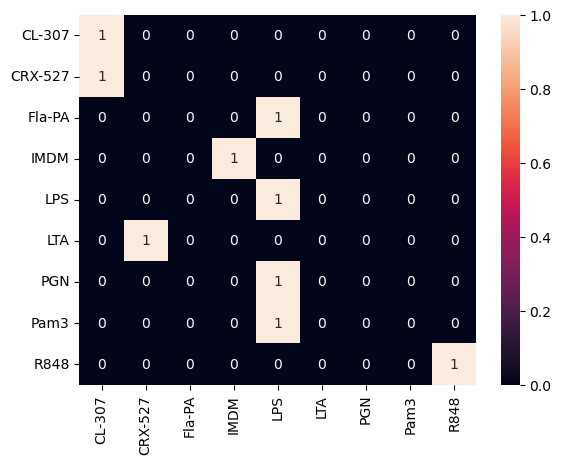

In [39]:
from sklearn.metrics import confusion_matrix

matrix = confusion_matrix(true_species, predicted_species)

confusion_df = pd.DataFrame(
    matrix, index=y_test.columns.values, columns=y_test.columns.values
)

sns.heatmap(confusion_df, annot=True)

In [40]:
from sklearn import metrics

statistics_dict = {}


def evaluate_model(name, real_labels, predicted_labels):
    accuracy, precision, recall, specificity, f1_score, confusion_matrix = (
        metrics.accuracy_score(real_labels, predicted_labels),
        metrics.precision_score(
            real_labels, predicted_labels, average="macro", zero_division=0
        ),
        metrics.recall_score(real_labels, predicted_labels, average="macro"),
        metrics.recall_score(real_labels, predicted_labels, average="macro"),
        metrics.f1_score(real_labels, predicted_labels, average="macro"),
        metrics.confusion_matrix(real_labels, predicted_labels),
    )
    statistics_dict[name] = {
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "Specificity": specificity,
        "F1 Score": f1_score,
        "Confusion Matrix": confusion_matrix,
    }
    return statistics_dict

In [41]:
evaluate_model("MATseq_NN_multiclass_classifier", true_species, predicted_species)

{'MATseq_NN_multiclass_classifier': {'Accuracy': 0.4444444444444444,
  'Precision': 0.3055555555555556,
  'Recall': 0.4444444444444444,
  'Specificity': 0.4444444444444444,
  'F1 Score': 0.34074074074074073,
  'Confusion Matrix': array([[1, 0, 0, 0, 0, 0, 0, 0, 0],
         [1, 0, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 1, 0, 0, 0, 0],
         [0, 0, 0, 1, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 1, 0, 0, 0, 0],
         [0, 1, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 1, 0, 0, 0, 0],
         [0, 0, 0, 0, 1, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0, 1]])}}

In [42]:
run.finish()

wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


In [43]:
run = wandb.init(project="NN-MATSeq")

model = keras.models.load_model("MATseq_NN_multiclass_classifier.keras")

cat: /sys/module/amdgpu/initstate: No such file or directory
ERROR:root:Driver not initialized (amdgpu not found in modules)


In [44]:
y_pred = model.predict(X_test)

1/1 [==============================] - 0s 50ms/step


In [45]:
prediction = pd.DataFrame(y_pred, columns=y_test.columns)
prediction.head()

,CL-307,CRX-527,Fla-PA,IMDM,LPS,LTA,PGN,Pam3,R848
0,0.002763,0.001495,0.000590,0.001001,0.063046,0.004466,0.003000,0.922990,0.000651
1,0.056760,0.010797,0.000207,0.000041,0.000289,0.000151,0.000011,0.000178,0.931566
2,0.005963,0.037366,0.028185,0.015352,0.745071,0.023142,0.100100,0.039875,0.004946
3,0.035088,0.942296,0.000185,0.000233,0.008093,0.004718,0.000178,0.004349,0.004858
4,0.003888,0.001016,0.006364,0.030473,0.953576,0.000110,0.001484,0.002619,0.000471


In [46]:
predicted_labels = prediction.idxmax(axis="columns")
true_labels = y_test.idxmax(axis="columns")

<Axes: >

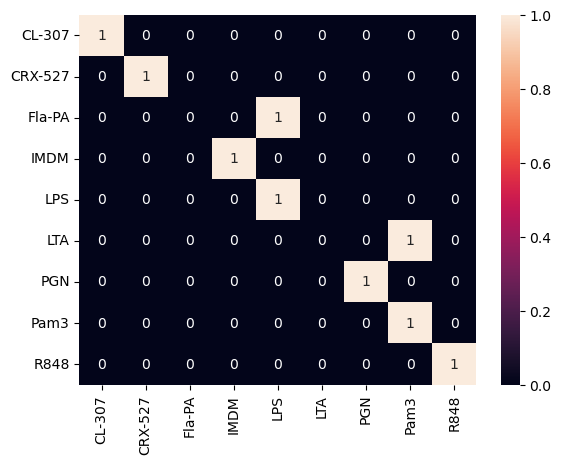

In [47]:
from sklearn.metrics import confusion_matrix

matrix = confusion_matrix(true_species, predicted_species)

confusion_df = pd.DataFrame(
    matrix, index=y_test.columns.values, columns=y_test.columns.values
)

sns.heatmap(confusion_df, annot=True)

In [97]:
from sklearn import metrics

statistics_dict = {}


def evaluate_model(name, real_labels, predicted_labels):
    accuracy, precision, recall, specificity, f1_score, confusion_matrix = (
        metrics.accuracy_score(real_labels, predicted_labels),
        metrics.precision_score(
            real_labels, predicted_labels, average="macro", zero_division=0
        ),
        metrics.recall_score(real_labels, predicted_labels, average="macro"),
        metrics.recall_score(real_labels, predicted_labels, average="macro"),
        metrics.f1_score(real_labels, predicted_labels, average="macro"),
        metrics.confusion_matrix(real_labels, predicted_labels),
    )
    statistics_dict[name] = {
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "Specificity": specificity,
        "F1 Score": f1_score,
        "Confusion Matrix": confusion_matrix,
    }
    return statistics_dict

In [49]:
evaluate_model("MATseq_NN_multiclass_classifier", true_labels, predicted_labels)

{'MATseq_NN_multiclass_classifier': {'Accuracy': 0.7777777777777778,
  'Precision': 0.6666666666666666,
  'Recall': 0.7777777777777778,
  'Specificity': 0.7777777777777778,
  'F1 Score': 0.7037037037037037,
  'Confusion Matrix': array([[1, 0, 0, 0, 0, 0, 0, 0, 0],
         [0, 1, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 1, 0, 0, 0, 0],
         [0, 0, 0, 1, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 1, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 1, 0],
         [0, 0, 0, 0, 0, 0, 1, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 1, 0],
         [0, 0, 0, 0, 0, 0, 0, 0, 1]])}}

In [50]:
run.finish()

wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Now to compare the NN model with MLPC.

## Checking perfromace of the trained model

In [95]:
import pickle

# Loads MLPC model
mlpc = pickle.load(open("MATseq_MLPC.model", "rb"))

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LabelBinarizer from version 0.24.2 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator MLPClassifier from version 0.24.2 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [173]:
from sklearn.feature_selection import chi2, SelectKBest
from sklearn.model_selection import LeaveOneOut

y = pd.Series(target, index=data_features.index)
X = data_features


loo = LeaveOneOut()
predicted_labels = []

for train_index, test_index in loo.split(X):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y[train_index], y[test_index]

    X_train = to_normalize_DESeq2_style(X_train)
    X_test = to_normalize_DESeq2_style(X_train)

    fs = SelectKBest(score_func=chi2, k=500)
    X_train = fs.fit_transform(X_train, y_train)
    X_test = fs.transform(X_test)

    model = mlpc
    model.fit(X_train, y_train)

    # Make predictions on the test fold
    y_pred = model.predict(X_test)
    predicted_labels.append(y_pred[0])  # Append the predicted label for this fold

TRAIN: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40] TEST: [0]
TRAIN: [ 0  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40] TEST: [1]
TRAIN: [ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40] TEST: [2]
TRAIN: [ 0  1  2  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40] TEST: [3]
TRAIN: [ 0  1  2  3  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40] TEST: [4]
TRAIN: [ 0  1  2  3  4  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40] TEST: [5]
TRAIN: [ 0  1  2  3  4  5  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40] TEST: [6]
TRAIN: [ 0  1  2  3 

In [ ]:
name = "MLPC"
evaluate_model(name, target, predicted_labels)

In [ ]:
default_config = {
    "l1": 32,
    "l2": 24,
    "batch_size": 12,
    "activation": "relu",
    "weights_limit": 0.001,
    "epochs": 320,
    "learning_rate": 0.002,
    "loss": "categorical_crossentropy",
    "optimizer": "adam",
    "dropout_rate1": 0.1,
    "dropout_rate2": 0.2,
}

In [178]:
loo = LeaveOneOut()
predicted_labels = []

y = pd.get_dummies(target, dtype=int)
X = data_features

for train_index, test_index in loo.split(X):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Normalize training and test sets within the loop
    X_train = to_normalize_DESeq2_style(X_train)
    X_test = to_normalize_DESeq2_style(X_test)

    fs = SelectKBest(score_func=chi2, k=500)
    X_train = fs.fit_transform(X_train, y_train)
    X_test = fs.transform(X_test)

    model = create_NN(
        X_train, y_train, X_test, y_test, default_config
    )  # Need to adjust this so that the model does not see the data before

    history = model.fit(
        X_train,
        y_train,
        epochs=320,
        batch_size=12,
        verbose=False,
    )

    y_pred = model.predict(X_test)
    prediction = pd.DataFrame(y_pred, columns=y_test.columns)

TRAIN: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40] TEST: [0]
1/1 [==============================] - 0s 49ms/step
TRAIN: [ 0  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40] TEST: [1]
1/1 [==============================] - 0s 49ms/step
TRAIN: [ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40] TEST: [2]
1/1 [==============================] - 0s 49ms/step
TRAIN: [ 0  1  2  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40] TEST: [3]
1/1 [==============================] - 0s 50ms/step
TRAIN: [ 0  1  2  3  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40] TEST: [4]
1/1 [==============================] - 0s 50ms/step
TRAIN: [ 0  1  2  3  4  6  7  8  9 10 11

In [169]:
predicted_labels = prediction.idxmax(axis="columns")
true_labels = y_test.idxmax(axis="columns")

<Axes: >

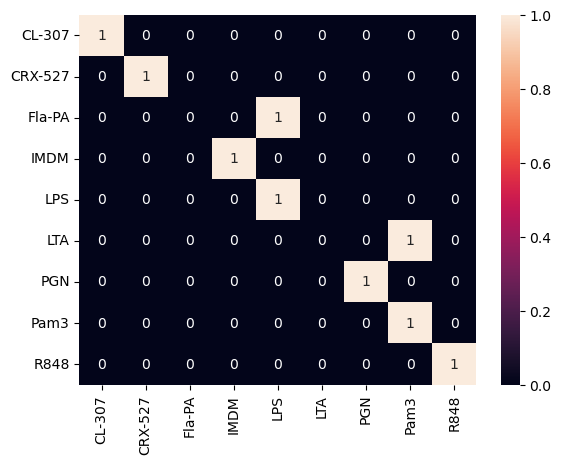

In [170]:
from sklearn.metrics import confusion_matrix

matrix = confusion_matrix(true_species, predicted_species)

confusion_df = pd.DataFrame(
    matrix, index=y_test.columns.values, columns=y_test.columns.values
)

sns.heatmap(confusion_df, annot=True)

In [171]:
evaluate_model("MATseq_NN_multiclass_classifier", true_species, predicted_species)

{'MATseq_NN_multiclass_classifier': {'Accuracy': 0.7777777777777778,
  'Precision': 0.6666666666666666,
  'Recall': 0.7777777777777778,
  'Specificity': 0.7777777777777778,
  'F1 Score': 0.7037037037037037,
  'Confusion Matrix': array([[1, 0, 0, 0, 0, 0, 0, 0, 0],
         [0, 1, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 1, 0, 0, 0, 0],
         [0, 0, 0, 1, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 1, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 1, 0],
         [0, 0, 0, 0, 0, 0, 1, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 1, 0],
         [0, 0, 0, 0, 0, 0, 0, 0, 1]])},
 'MLPC': {'Accuracy': 0.0975609756097561,
  'Precision': 0.011111111111111112,
  'Recall': 0.08888888888888889,
  'Specificity': 0.08888888888888889,
  'F1 Score': 0.01975308641975309,
  'Confusion Matrix': array([[0, 0, 0, 0, 0, 0, 0, 0, 5],
         [0, 0, 0, 0, 0, 0, 0, 0, 5],
         [0, 0, 0, 0, 0, 0, 0, 0, 3],
         [0, 0, 0, 0, 0, 0, 0, 0, 5],
         [0, 0, 0, 0, 0, 0, 0, 0, 5],
         [0, 0, 0, 0, 0, 0, 0, 0,

I will try with data Bruno has chosen to train MLPC originally.

In [1]:
def get_pyrogen_name(sample_name_list):
    output = []
    for sample in sample_name_list:
        output.append(sample.split("_")[1])
    return output

In [3]:
import os
import pandas as pd

filenamelist = [
    "BA034_raw_reads.csv",
    "BA044_raw_reads.csv",
    "BA051_raw_reads.csv",
    "BA061_raw_reads.csv",
    "BA064_raw_reads.csv",
]

# loads all seq datasets
path = "~/MATseq/notebooks/support_files"


# loads metadata
all_metadata = pd.read_csv(
    os.path.join(path, "all_metadata.csv"),
    encoding="utf8",
    sep=";",
    index_col="index",
)

metadata = list(
    all_metadata[
        ((all_metadata["include_in_model"] == True))
        & (all_metadata["exclude_from_model"] == False)
    ].index
)

raw_reads_df = pd.DataFrame()
for filename in filenamelist:
    temp_df = pd.read_csv(
        os.path.join(path, filename), encoding="utf8", index_col="gene"
    )
    raw_reads_df = raw_reads_df.join(temp_df, how="right")

raw_reads_df.reset_index(inplace=True, drop=False)

# make sample names uniform
new_columns = ("&").join(list(raw_reads_df.columns))

new_columns = new_columns.replace("control", "IMDM")
new_columns = new_columns.replace("CL307", "CL-307")
new_columns = new_columns.replace("Albu", "AH1252")
new_columns = new_columns.replace("cAlb", "AH1397")
new_columns = new_columns.replace("Alb2", "AH1405")
new_columns = new_columns.replace("LPS_PGN", "LPS-PGN")
new_columns = new_columns.replace("LPS_R848", "LPS-R848")
new_columns = new_columns.replace("Pam3_PGN", "Pam3-PGN")
new_columns = new_columns.replace("Pam3_R848", "Pam3-R848")
new_columns = new_columns.replace("PAM3", "Pam3")
new_columns = new_columns.replace("Fla-ST", "Fla-St")
new_columns = new_columns.replace("TL8", "TL8-506")
new_columns = new_columns.replace("CL8", "TL8-506")

new_columns = new_columns.split("&")
raw_reads_df.columns = new_columns

included_raw_reads = raw_reads_df[metadata].copy()
# included_raw_reads["gene"] = raw_reads_df["gene"]


sample_name_list = get_pyrogen_name(set(included_raw_reads.columns[:-1]))

# print("current samples:", list(set(sample_name_list)))

In [4]:
included_raw_reads.head()

,BA029_CL-307_22,BA029_CL-307_23,BA029_CL-307_24,BA046_CL-307_21,BA046_CL-307_22,BA046_CL-307_23,BA046_CRX-527_10,BA046_CRX-527_11,BA046_CRX-527_12,BA046_CRX-527_9,...,BA029_PGN_14,BA029_PGN_16,BA046_PGN_17,BA046_PGN_18,BA046_PGN_20,BA028_R848_13,BA028_R848_15,BA028_R848_16,BA059_R848_10,BA059_R848_11
0,0,0,0,0,2,3,0,0,0,1,...,0,0,1,0,0,0,0,2,1,1
1,88,35,96,91,252,152,68,35,41,210,...,36,76,184,49,128,72,52,125,220,282
2,33,4,17,24,71,41,14,5,1,55,...,19,22,56,28,47,31,10,41,51,84
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,135,63,180,204,464,293,102,63,64,357,...,141,170,510,288,345,138,128,242,386,500


In [5]:
def raw_to_rpm(DataFrame):
    outputDF = pd.DataFrame()
    for sample in DataFrame.columns:
        total_reads = DataFrame[sample].sum()
        outputDF[sample] = DataFrame[sample].apply(
            lambda x: (x / total_reads) * 1000000
        )
    return outputDF


included_reads_rpm = raw_to_rpm(included_raw_reads)

index_rpm_under_10 = []
for gene in included_reads_rpm.index:
    if included_reads_rpm.loc[gene].max() < 10:
        index_rpm_under_10.append(gene)

print(len(index_rpm_under_10), "genes under 10 rpm.")

9618 genes under 10 rpm.


In [6]:
included_raw_reads = included_raw_reads.drop(index_rpm_under_10, axis=0)

In [7]:
target = [("_").join(i.split("_")[1:2]) for i in included_raw_reads]

In [8]:
from scipy.stats import zscore


def raw_to_zscore(DataFrame):
    outputDF = pd.DataFrame(
        zscore(DataFrame, axis=0), index=DataFrame.index, columns=DataFrame.columns
    )
    return outputDF


data_features = raw_to_zscore(included_raw_reads)

In [9]:
# Define the best parameters
params = {
    "activation": "relu",
    "alpha": 0.0001,
    "batch_size": "auto",
    "beta_1": 0.9,
    "beta_2": 0.999,
    "early_stopping": False,
    "epsilon": 1e-08,
    "hidden_layer_sizes": (100,),
    "learning_rate": "constant",
    "learning_rate_init": 0.001,
    "max_fun": 15000,
    "max_iter": 600,
    "momentum": 0.9,
    "n_iter_no_change": 10,
    "nesterovs_momentum": True,
    "power_t": 0.5,
    "random_state": 0,
    "shuffle": True,
    "solver": "adam",
    "tol": 0.0001,
    "validation_fraction": 0.1,
    "verbose": False,
    "warm_start": False,
}

In [11]:
import pickle
from sklearn.model_selection import LeaveOneOut
from sklearn.neural_network import MLPClassifier

y = pd.Series(target, index=data_features.T.index)
X = data_features.T


loo = LeaveOneOut()
predicted_labels = []

for train_index, test_index in loo.split(X):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y[train_index], y[test_index]

    model = MLPClassifier(**params)

    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    predicted_labels.append(y_pred[0])

TRAIN: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64] TEST: [0]
TRAIN: [ 0  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64] TEST: [1]
TRAIN: [ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64] TEST: [2]
TRAIN: [ 0  1  2  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64] TEST: [3]
TRAIN: [ 0  1  2  3  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 4

In [12]:
name = "MLPC"
evaluate_model(name, target, predicted_labels)

NameError: name 'evaluate_model' is not defined

In [ ]:
from sklearn.metrics import confusion_matrix

matrix = confusion_matrix(target, predicted_labels)

confusion_df = pd.DataFrame(
    matrix, index=y_test.columns.values, columns=y_test.columns.values
)

sns.heatmap(confusion_df, annot=True)

In [14]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import LeaveOneOut

y = pd.Series(target, index=data_features.T.index)
X = data_features.T


loo = LeaveOneOut()
predicted_labels = []

# Define the best parameters
params = {
    "activation": "relu",
    "alpha": 0.0001,
    "batch_size": "auto",
    "beta_1": 0.9,
    "beta_2": 0.999,
    "early_stopping": False,
    "epsilon": 1e-08,
    "hidden_layer_sizes": (100,),
    "learning_rate": "constant",
    "learning_rate_init": 0.001,
    "max_fun": 15000,
    "max_iter": 600,
    "momentum": 0.9,
    "n_iter_no_change": 10,
    "nesterovs_momentum": True,
    "power_t": 0.5,
    "random_state": 0,
    "shuffle": True,
    "solver": "adam",
    "tol": 0.0001,
    "validation_fraction": 0.1,
    "verbose": False,
    "warm_start": False,
}


for train_index, test_index in loo.split(X):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y[train_index], y[test_index]

    model = sklearn.neural_network.MLPClassifier(**params)

    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    predicted_labels.append(y_pred[0])

TRAIN: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64] TEST: [0]
TRAIN: [ 0  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64] TEST: [1]
TRAIN: [ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64] TEST: [2]
TRAIN: [ 0  1  2  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64] TEST: [3]
TRAIN: [ 0  1  2  3  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 4

In [16]:
speak("Finished!")

In [19]:
name = "MLPC"
evaluate_model(name, target, predicted_labels)

{'MLPC': {'Accuracy': 0.9692307692307692,
  'Precision': 0.9861111111111112,
  'Recall': 0.9259259259259258,
  'Specificity': 0.9259259259259258,
  'F1 Score': 0.9370370370370371,
  'Confusion Matrix': array([[ 6,  0,  0,  0,  0,  0,  0,  0,  0],
         [ 0,  7,  0,  0,  0,  0,  0,  0,  0],
         [ 0,  0,  1,  0,  2,  0,  0,  0,  0],
         [ 0,  0,  0, 16,  0,  0,  0,  0,  0],
         [ 0,  0,  0,  0, 14,  0,  0,  0,  0],
         [ 0,  0,  0,  0,  0,  3,  0,  0,  0],
         [ 0,  0,  0,  0,  0,  0,  5,  0,  0],
         [ 0,  0,  0,  0,  0,  0,  0,  6,  0],
         [ 0,  0,  0,  0,  0,  0,  0,  0,  5]])}}

Need to adjust number of input to have a fair comparison with MLPC

In [106]:
default_config = {
    "l1": 32,
    "l2": 24,
    "batch_size": 12,
    "activation": "relu",
    "weights_limit": 0.001,
    "epochs": 320,
    "learning_rate": 0.002,
    "loss": "categorical_crossentropy",
    "optimizer": "adam",
    "dropout_rate1": 0.1,
    "dropout_rate2": 0.2,
}

In [107]:
def create_nn(X_train, config=default_config):
    batch_size = config.get("batch_size")
    activation = config.get("activation")
    weights_limit = config.get("weights_limit")
    epochs = config.get("epochs")
    learning_rate = config.get("learning_rate")
    loss = config.get("loss")
    l1 = config.get("l1")
    l2 = config.get("l2")
    dropout_rate1 = config.get("dropout_rate1")
    dropout_rate2 = config.get("dropout_rate2")

    optimizer_name = config.get("optimizer")
    if optimizer_name == "adam":
        optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    elif optimizer_name == "sgd":
        optimizer = keras.optimizers.SGD(learning_rate=learning_rate)
    elif optimizer_name == "rmsprop":
        optimizer = keras.optimizers.RMSprop(learning_rate=learning_rate)

    inputs = keras.Input(shape=X_train.shape[1])
    x = keras.layers.UnitNormalization()(inputs)

    x = keras.layers.Dense(
        l1,
        activation=activation,
        kernel_regularizer=keras.regularizers.L2(weights_limit),
    )(x)
    x = keras.layers.Dropout(dropout_rate1)(x)

    x = keras.layers.Dense(
        l2,
        activation=activation,
        kernel_regularizer=keras.regularizers.L2(weights_limit),
    )(x)
    x = keras.layers.Dropout(dropout_rate2)(x)

    outputs = keras.layers.Dense(9, activation="softmax")(x)

    model = keras.Model(
        inputs=inputs, outputs=outputs, name="NN_multiclass_classifier_MATseq"
    )

    model.compile(
        optimizer=optimizer,
        loss=loss,
        metrics=[
            "accuracy",
            keras.metrics.AUC(name="auc"),
        ],
    )

    return model

In [151]:
loo = LeaveOneOut()

prediction = pd.DataFrame(columns=y.columns)

y = pd.get_dummies(target, dtype=int)
X = data_features.T

for train_index, test_index in loo.split(X):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    nn = create_nn(X_train)

    nn.fit(
        X_train,
        y_train,
        epochs=320,
        batch_size=12,
        verbose=False,
    )

    y_pred = nn.predict(X_test)
    prediction_on_fold = pd.DataFrame(y_pred, columns=y_test.columns)
    prediction = pd.concat([prediction, prediction_on_fold])

TRAIN: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64] TEST: [0]
1/1 [==============================] - 0s 50ms/step
TRAIN: [ 0  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64] TEST: [1]
1/1 [==============================] - 0s 49ms/step
TRAIN: [ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64] TEST: [2]
1/1 [==============================] - 0s 48ms/step
TRAIN: [ 0  1  2  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64] TE

In [33]:
nn.summary()

NameError: name 'nn' is not defined

In [11]:
def speak(text):
    from IPython.display import Javascript as js, clear_output

    text = text.replace("'", r"\'")
    display(
        js(
            f"""
    if(window.speechSynthesis) {{
        var synth = window.speechSynthesis;
        synth.speak(new window.SpeechSynthesisUtterance('{text}'));
    }}
    """
        )
    )
    # Clear the JS so that the notebook doesn't speak again when reopened/refreshed
    clear_output(False)

In [222]:
speak("Finished!")

In [228]:
predicted_labels = prediction.idxmax(axis="columns")
true_labels = target

<Axes: >

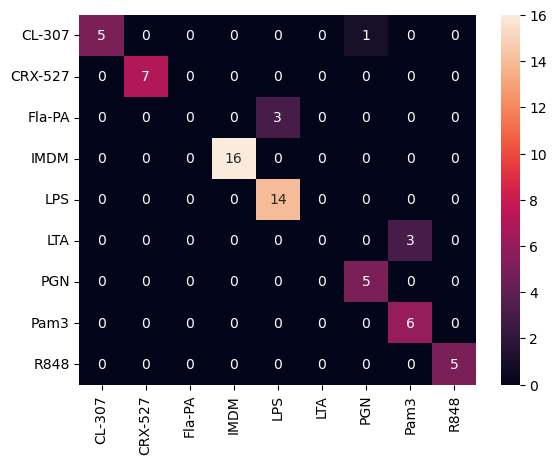

In [230]:
from sklearn.metrics import confusion_matrix

matrix = confusion_matrix(true_labels, predicted_labels)

confusion_df = pd.DataFrame(
    matrix, index=y_test.columns.values, columns=y_test.columns.values
)

sns.heatmap(confusion_df, annot=True)

In [231]:
evaluate_model("MATseq_NN_multiclass_classifier", true_labels, predicted_labels)

{'MATseq_NN_multiclass_classifier': {'Accuracy': 0.8923076923076924,
  'Precision': 0.7026143790849673,
  'Recall': 0.7592592592592593,
  'Specificity': 0.7592592592592593,
  'F1 Score': 0.7246008471814923,
  'Confusion Matrix': array([[ 5,  0,  0,  0,  0,  0,  1,  0,  0],
         [ 0,  7,  0,  0,  0,  0,  0,  0,  0],
         [ 0,  0,  0,  0,  3,  0,  0,  0,  0],
         [ 0,  0,  0, 16,  0,  0,  0,  0,  0],
         [ 0,  0,  0,  0, 14,  0,  0,  0,  0],
         [ 0,  0,  0,  0,  0,  0,  0,  3,  0],
         [ 0,  0,  0,  0,  0,  0,  5,  0,  0],
         [ 0,  0,  0,  0,  0,  0,  0,  6,  0],
         [ 0,  0,  0,  0,  0,  0,  0,  0,  5]])}}

In [ ]:
import matplotlib.pyplot as plt
from sklearn import metrics

# Calculate the number of columns for subplots
num_models = len(statistics_dict)
num_columns = min(3, num_models)  # You can change the number of columns as needed
num_rows = -(-num_models // num_columns)  # Calculate the number of rows needed

# Create a new figure with subplots
fig, axes = plt.subplots(num_rows, num_columns, figsize=(15, 5))

# Flatten the axes array if there's only one row
if num_rows == 1:
    axes = [axes]

for i, (model, model_stats) in enumerate(statistics_dict.items()):
    print(f"Model: {model}")
    for metric, value in model_stats.items():
        print(f"{metric}: {value}")

    # Calculate the subplot position
    row = i // num_columns
    col = i % num_columns

    # Create a confusion matrix display for each model
    cm_display = metrics.ConfusionMatrixDisplay(
        confusion_matrix=statistics_dict[model]["Confusion Matrix"],
        display_labels=mlpc.classes_,  # Make sure to specify the appropriate class labels
    )

    # Plot the confusion matrix display in the corresponding subplot
    cm_display.plot(ax=axes[row][col])
    axes[row][col].set_xlabel("Predicted Labels")
    axes[row][col].set_ylabel("True Labels")
    axes[row][col].set_title(f"{model}")

# Adjust spacing between subplots and display the figure
plt.tight_layout()
plt.show()